# Comparons les différentes méthodes de régressions symboliques

## Pour le probleme 2


### Import des données, des librairies et def des fonctions

In [1]:
import os 
os.chdir('/vol/usersmeca2/challier')
os.getcwd()

'/vol/usersmeca2/challier'

In [2]:
import UTILS.TOOLS.fct_readsunfluidhdata as rsd # import the reading routines as rsd
import matplotlib.pyplot as plt
import numpy as np
from UTILS.TOOLS.tools_hdf5_m import *
import h5py
from pathlib import Path
from UTILS.TOOLS.tools_subplot import *
import matplotlib.colors as mcolors
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
#from pysindy import FiniteDifference
import pysindy as ps
import kan
import torch
import time
from torch import autograd
from tqdm import tqdm

plt.rcParams.update({ # +6partout, +4 titres, -2 ticks&legend, +2 axeslabel, +4partout
    'font.size': 24,            # Police globale plus grande
    'axes.titlesize': 30,       # Titres d'axes bien visibles
    'axes.labelsize': 26,       # Labels d'axes
    'xtick.labelsize': 20,      # Taille des ticks
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif'],
    'mathtext.fontset': 'dejavuserif',
    "text.usetex": False,
    # "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    # 'mathtext.fontset': 'cm',
    'lines.linewidth': 2,
    'axes.linewidth': 1.2,
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    'legend.frameon': True,
    'figure.dpi': 150,           # Pour une meilleure résolution
    'savefig.dpi': 300,          # Pour les figures exportées
})

# recupère les coupes
def recup_slices(n_run, slicedir, sliceid, idtime, nlaps, champs): 
    datafilename = f"/workdir/challier/SLICE_H5_RUN{n_run}" + f'/slice_{sliceid:02d}_' + f'{slicedir}_' + f'{idtime:07d}' + '.h5'
    #keys_file=Read_H5_Spav(datafilename,keyreading=True)
    xxh,yyh=Read_H5_Spav(datafilename,gridreading=True)


    slices = np.zeros([len(xxh), len(yyh), len(nlaps), len(champs)])
    tt = np.zeros(len(nlaps))


    for n in range(len(nlaps)):  
        idtime = nlaps[n]
        datafilename = f"/workdir/challier/SLICE_H5_RUN{n_run}" + f'/slice_{sliceid:02d}_' + f'{slicedir}_' + f'{idtime:07d}' + '.h5'
        

        for i, c in enumerate(champs) : 
            time,fields=Read_H5_Spav(datafilename, c)
            slices[:,:, n, i] = fields

        tt[n] = time


    return slices, xxh, yyh, tt

# normalisation
def normalize(X):
    if type(X)==np.ndarray:
        X_mean = np.mean(X, axis=(0, 1))
        X_std = np.std(X, axis=(0, 1))
    elif type(X)==torch.Tensor:
        X_mean = torch.mean(X, axis=[0, 1])
        X_std = torch.std(X, axis=[0, 1])
    else:
        raise ValueError('Type not supported')
    X_normed = (X - X_mean )/ X_std
    return X_normed, X_mean, X_std

def unormalize(X_normed, X_mean, X_std):
    X_unormed = X_normed * X_std + X_mean
    return X_unormed

def reshp(X):
    return X.reshape(X.shape[0]*X.shape[1], X.shape[2])

# device cpu pour grappe
device = 'cpu'

Import des données et découpe de la slice.

In [3]:
# run 1

########## Parametres des slices ##########
n_run = 1
slicedir = 2
sliceid = 7
idtime = 5886

## temps run1 : 5886 
## temps run2 : 6353
## temps run3 : 6820 (ntime=466)
## temps run4 : 7286

ntime = 467 # number of instants (nombre)
nfin = int(idtime+ntime-1) # issue of instants (numero fin)
nech=1

nlaps = np.arange (idtime,nfin+1,nech)
champs = ['U','W','T']
##########################################

## recupere les slices

slices_r1, xxh, zzh, tt_r1 = recup_slices(n_run, slicedir, 
                            sliceid, idtime, nlaps, champs)

### coupe la slice
# - 320 : prend le x au centre 
# - [:125] : zoom sur le z pour avoir que les 0.1 prems
# - [293:393] : prend un bout de temps -> 293.5 to 295.5
# - [268:368] : prend un bout de temps -> 293 to 295
# - [121:368] : prend un bout de temps -> 290.0 to 295
# - garde tous les champs

X = slices_r1[320,:125,194:368,:].astype(np.float32)
t = tt_r1[194:368].astype(np.float32)
z = zzh[:125].astype(np.float32)
num_pb = 23 # 1 pour [293.5, 295.5] et 12 pour [293.0, 295.0]
            # 13 pour 290-292 -> 194:368 et 24 pour l'ajout de x en plus ou laors faire un autre notebook ?
############

cond_lim = True 
if cond_lim :
    # ajout des cond limites en z=0

    a = np.zeros((1, len(t), 2))
    b = np.ones((1, len(t), 1))
    A = np.concatenate((a, b), axis=2)

    X= np.concatenate((A, X), axis=0)
    z= np.concatenate((np.zeros(1), z))

    # il faudrait que j'interpole pour les z entre z=0 et z[0] ?
# X = np.transpose(X, axes=(1,0,2))
X.shape # dimension (z, t, champs)
X = np.transpose(X, (1, 0, 2))
X.shape # dimension (t, x, z, champs) ou (t, z, champs)


(174, 126, 3)

In [81]:
# couche limite 
slices_r1.shape # x, z, t, c
yyh = np.gradient(slices_r1[:,:,:,0], zzh, axis=1, edge_order=2) # shape x, z, t
pr = 4.38
ra = 2e09
yyh.mean(axis=(0, -1))[0]
delta_nu = (pr/ra)**(1/4) * (yyh.mean(axis=(0, -1))[0])**(-1/2)
delta_nu


0.002205592513489272

### Traitement des données   
- calcul des dérivées temporelles $t$ et spatiales en $z$ avec les différences finies
- création des entrées et des sorties
- normalisaton
- split train/test

In [82]:
t.shape

(174,)

In [4]:
# créer notre label y : les dérivées verticales
y = np.gradient(X[:,:,[0,2]], z, axis=1, edge_order=2)

# calcule les derivées spatiales : pour les KANs, SINDy les calculs directements avec la librairie de fonction pour les PDEs
Xt = np.gradient(X, t, axis=0, edge_order=2) 
Xtt = np.gradient(Xt, t, axis=0, edge_order=2) 

# sort le maillage pour les KANs et la librairie WeakPDE # ptetre pas utile ? nan pas utile
TIME, Z = np.meshgrid(t, z)
ZT = np.concatenate(( Z.reshape(len(z), len(t), 1), TIME.reshape(len(z), len(t), 1)), axis=2) 

# et créer la matrice d'entrée pour les KANs et la convertit en tenseur plus tard
X_kan = np.concatenate((X, Xt), axis=2)
X_sindy = X
y_kan = y
y_sindy = y

# normalisation des données 
normalisation = True
if normalisation : # pour les KANs, + SINDy aussi //SINDy normalise directement dans l'entraînement//
    X_kan, mean_X_kan, std_X_kan = normalize(X_kan)
    #y_kan, mean_y_kan, std_y_kan = normalize(y_kan)
    #X_sindy, mean_X_sindy, std_X_sindy = normalize(X_sindy) ## X et y reste sans normalisation => utile pour les visualisations
    #y_sindy, mean_y_sindy, std_y_sindy = normalize(y_sindy)

# split train/test 0.70/0.30%
tscv = TimeSeriesSplit(n_splits=2, test_size=int(t.size*0.3))
all_splits = list(tscv.split(t))
train_id, test_id = all_splits[1]   # prend train 0-79 et test 80-99

# split KANs dans un dictionnaire
# on ne peut pas utiliser le create_datasets_from_data de kan 
# car il y a un random.choice qui n'est pas compatible pour les TimesSeries
nb_features = X_kan.shape[2]
data_kan = {} # on reshape directement les données // ptetre fonctionne sans reshape ?? NON forcément (nb_obs, nb_features)
data_kan['train_input'] = torch.tensor(X_kan[train_id,:,:].reshape(len(z)*len(train_id), nb_features), dtype=torch.float32, device=device)
data_kan['test_input'] = torch.tensor(X_kan[test_id,:,:].reshape(len(z)*len(test_id), nb_features), dtype=torch.float32, device=device)
data_kan['train_label'] = torch.tensor(y_kan[train_id,:,:].reshape(len(z)*len(train_id), 2), dtype=torch.float32, device=device)
data_kan['test_label'] = torch.tensor(y_kan[test_id,:,:].reshape(len(z)*len(test_id), 2), dtype=torch.float32, device=device)

# split SINDy
X_train = X_sindy[train_id,:, :]
X_test = X_sindy[test_id, :,:]
y_train = y_sindy[train_id,:, :]
y_test = y_sindy[test_id,:, :]
t_train, t_test = t[train_id], t[test_id]  



## Définition et entraînement des modèles 

Maintenant que les données sont préparées, nous pouvons définir et entraîner les modèles.
Il faut créer les librairies de fonctions pour les modèles SINDy et WeakSINDy.
Définir les optimiseurs et leurs paramètres.

Les modèles ont les mêmes données d'entrée. Cependant, on ne leur donne pas de la même manière. SINDy construit une librairie de fonctions avec les dérivées spatiales en $z$ et prends des données d'entrée de dimension $(125, 100, 3)$ avec nos trois champs $[u, w, T]$. Alors que pour les KANs il faut applatir les données d'entrée, on ajoute le maillage de la fonction `np.meshgrid(t, z)` pour que le modèles puisse prendre en compte la struction spatio-temporelle des données. De plus, il faut ajouter les dérivées spatiales en $z$ pour que le modèle ait autant d'information que SINDy. On se retrouve donc avec une matrice d'entrée de dimension $(125 \times 100, 11)$.

### Les hyperparamètres 

Pour le modèle SINDy :
- library_functions : librairie de fonctions
- derivative order : ordre de dérivée
- include_bias : inclure un terme de biais
- include_interaction : autoriser les interactions entre les fonctions
- K : nombre de sous-domaines pour la formulation faible des PDEs

Pour le modèle KAN : 
- width : profondeur du réseau et nombre de neurones
- grid : nombre d'intervalles pour les splines
- k : ordre des polynômes

Pour l'optimisation : 
- optimizer : optimiseur de la fonction de coût
- threshold : seuil de coût

### PDE-SINDy

In [84]:
y_train.shape

(122, 126, 2)

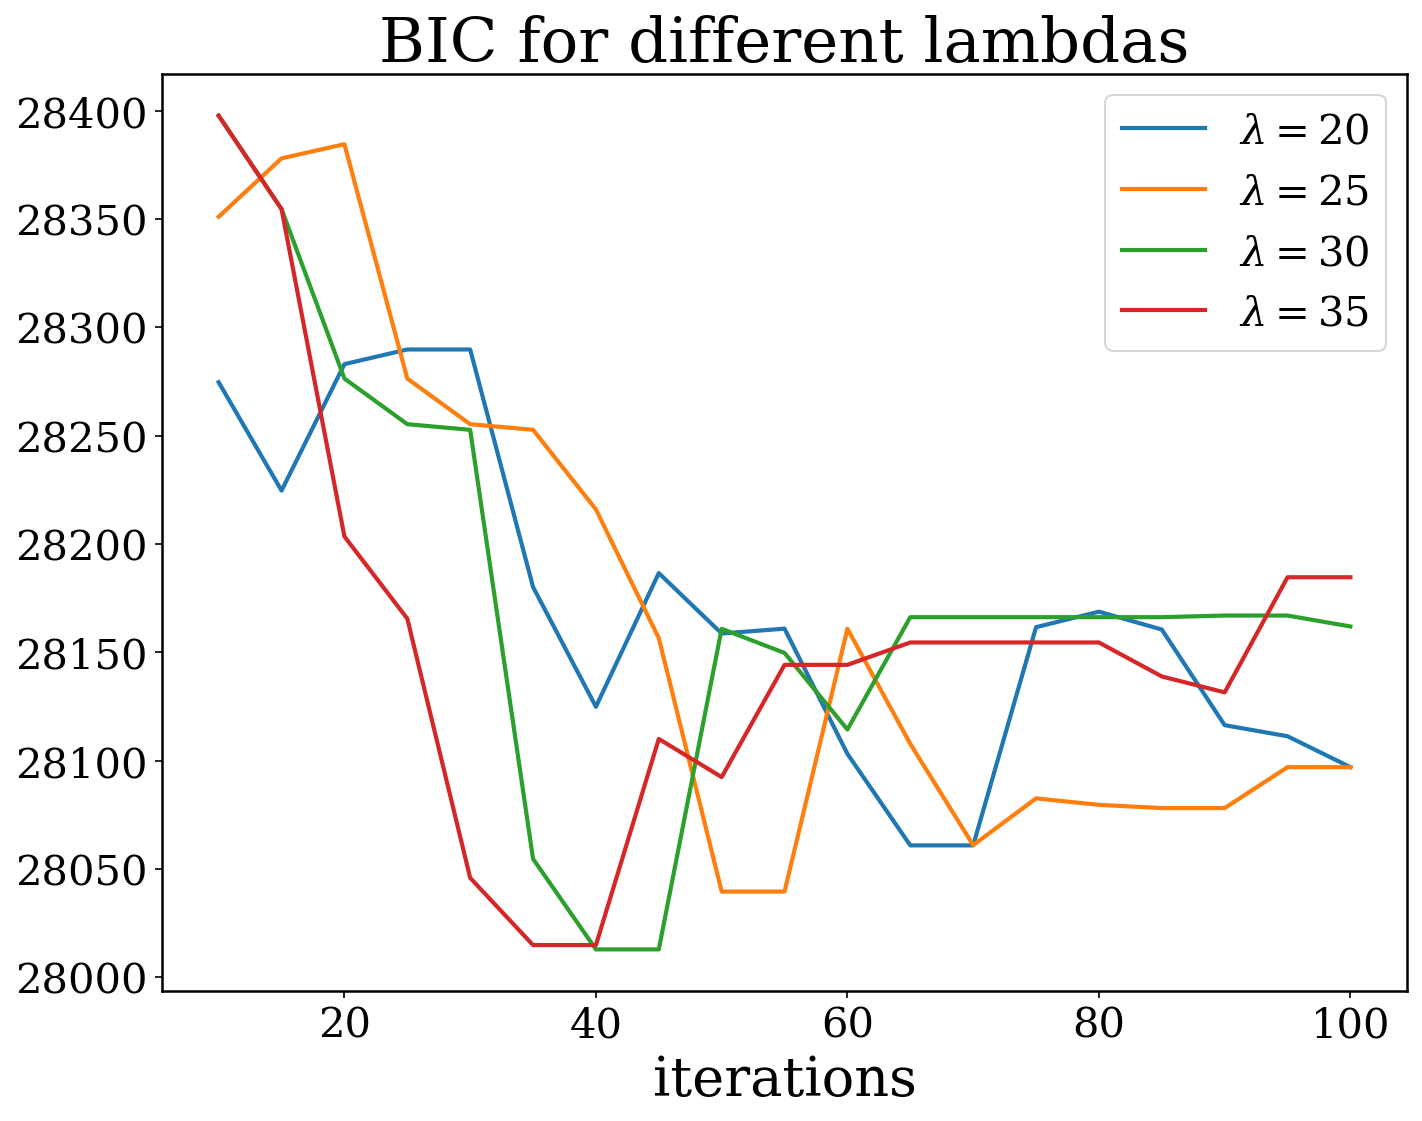

In [8]:
# choix de lambda
lamb_list = [20, 25, 30, 35]
nu_list = [0.5]
np.random.seed(1501)

plt.figure(figsize=(10, 8))
ax1 = plt.subplot(111)
#ax2 = plt.subplot(122)

for lamb in lamb_list : 
    for nu in nu_list : 
        # SINDy avec PDELibrary
        # création des librairies de fonctions

        library_functions = [lambda x: x]
        library_function_names = [lambda x: x]

        # pour SINDy 
        pde_lib = ps.PDELibrary(library_functions=library_functions, 
                                function_names=library_function_names, 
                                derivative_order=2, 
                                spatial_grid=t_train, # grille temporelle
                                include_bias=True,
                                include_interaction=True,
                                is_uniform=False,
                                )

        pde_lib_test = ps.PDELibrary(library_functions=library_functions, 
                                function_names=library_function_names, 
                                derivative_order=2, 
                                spatial_grid=t_test, # grille temporelle 
                                include_bias=True,
                                include_interaction=True,
                                is_uniform=False)

        ### Pour SR3
        ## Pour STLSQ on a juste a modif opt_sindy et les titres

        MAE_train, MAE_test = [], []
        R2_train, R2_test = [], []
        MSE_train, MSE_test = [], []
        MAPE_train, MAPE_test = [], []
        compl = []
        n_iters = 100

        opt_sindy = ps.SR3(threshold=lamb, thresholder='l1', normalize_columns=True, max_iter=n_iters, verbose=False, tol=1e-5, nu=nu)
        # opt_sindy = ps.STLSQ(threshold=30, alpha=1e-5, normalize_columns=True, verbose=False, max_iter=n_iters)
        model_sindy = ps.SINDy(feature_library=pde_lib, optimizer=opt_sindy, feature_names=['u', 'w', 'T'])

        iters = range(10, n_iters+1, 5)
        for i in iters:
            # opt_sindy = ps.SR3(threshold=2, thresholder='l1', normalize_columns=True, max_iter=i, verbose=False, tol=1e-5, nu=1)
            # # opt_sindy = ps.STLSQ(threshold=30, alpha=1e-5, normalize_columns=True, verbose=False, max_iter=n_iters)
            # model_sindy = ps.SINDy(feature_library=pde_lib, optimizer=opt_sindy, feature_names=['u', 'w', 'T'])
            model_sindy.optimizer.max_iter = i
            model_sindy.fit(X_train, x_dot=y_train, quiet=True)

            # metric train/test
            coef = model_sindy.coefficients()
            train_transf = pde_lib.fit_transform(X_train)
            train_pred = train_transf @ coef.T
            test_transf = pde_lib_test.fit_transform(X_test)
            test_pred = test_transf @ coef.T
            MAE_train.append(np.mean(np.abs(train_pred-y_train)))
            MAE_test.append(np.mean(np.abs(test_pred-y_test)))
            R2_train.append(1 - np.mean((train_pred-y_train)**2) / np.mean((y_train - y_train.mean(axis=(0, 1)))**2)  )
            R2_test.append(1 - np.mean((test_pred-y_test)**2) / np.mean((y_test - y_test.mean(axis=(0, 1)))**2)  )
            MSE_train.append(np.mean((train_pred-y_train)**2))
            MSE_test.append(np.mean((test_pred-y_test)**2))
            # MAPE_train.append(model_sindy.score(X_train, t=dt, metric=mean_absolute_percentage_error))
            # MAPE_test.append(model_sindy.score(X_test, t=dt, metric=mean_absolute_percentage_error))
            compl.append(model_sindy.complexity)

        nb_coeff = model_sindy.coefficients().shape
        n_train = len(t_train) * len(z)
        n_test = len(t_test)* len(z)
        AIC_test = n_test * np.log(MSE_test) + 2* np.array(compl)
        AIC_train = n_train * np.log(MSE_train) + 2* np.array(compl)
        BIC_test = n_test * np.log(MSE_test) + np.log(n_test)* np.array(compl)
        BIC_train = n_train * np.log(MSE_train) + np.log(n_train)* np.array(compl)

        # print(r"Modèle SINDy-PDE avec SR3:")
        # print("     Nombre de coefficients d'apprentissage :", nb_coeff)
        # print("     Complexité du modèle :", compl[-1])
        # print("     R2 score | training : ", R2_train[-1], "| testing : ", R2_test[-1]) # r2 
        # print("     MSE score | training : ", MSE_train[-1], "| testing : ", MSE_test[-1]) # r2 
        # print("     MAE score | training : ", MAE_train[-1], "| testing : ", MAE_test[-1]) # mse
        # print("     BIC : ", BIC_train[-1], "| AIC : ", AIC_train[-1])
        # print('\n\n')
        # model_sindy.print()

        ax1.plot(iters, BIC_test, label=r'$\lambda=$'+f'{lamb}')
        #ax2.plot(iters, R2_test)




ax1.legend()
plt.title('BIC for different lambdas')
ax1.set_xlabel('iterations')
plt.tight_layout()

plt.savefig(f'FIGURES/pb{num_pb}_bic_sindy.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_bic_sindy.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()

In [9]:
# SINDy avec PDELibrary
# création des librairies de fonctions
library_functions = [lambda x: x]
library_function_names = [lambda x: x]

# pour SINDy 
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=1, 
                        spatial_grid=t_train, # grille temporelle
                        include_bias=True,
                        include_interaction=True,
                        is_uniform=False,
                        )

pde_lib_test = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=1, 
                        spatial_grid=t_test, # grille temporelle 
                        include_bias=True,
                        include_interaction=True,
                        is_uniform=False)

### Pour SR3
## Pour STLSQ on a juste a modif opt_sindy et les titres

MAE_train, MAE_test = [], []
R2_train, R2_test = [], []
MSE_train, MSE_test = [], []
MAPE_train, MAPE_test = [], []
compl = []
n_iters = 40

opt_sindy = ps.SR3(threshold=30, thresholder='l1', normalize_columns=True, max_iter=n_iters, verbose=False, tol=1e-5, nu=.5)
# opt_sindy = ps.STLSQ(threshold=30, alpha=1e-5, normalize_columns=True, verbose=False, max_iter=n_iters)
model_sindy = ps.SINDy(feature_library=pde_lib, optimizer=opt_sindy, feature_names=['u', 'w', 'T'])
sindy_iters_complet = range(1, n_iters+1)
sindy_iters = range(10, n_iters+1, 10)
for i in sindy_iters:
    model_sindy.optimizer.max_iter = i
    model_sindy.fit(X_train, x_dot=y_train, quiet=True)

    # metric train/test
    coef = model_sindy.coefficients()
    train_transf = pde_lib.fit_transform(X_train)
    train_pred = train_transf @ coef.T
    test_transf = pde_lib_test.fit_transform(X_test)
    test_pred = test_transf @ coef.T
    MAE_train.append(np.mean(np.abs(train_pred-y_train)))
    MAE_test.append(np.mean(np.abs(test_pred-y_test)))
    R2_train.append(1 - np.mean((train_pred-y_train)**2) / np.mean((y_train - y_train.mean(axis=(0, 1)))**2)  )
    R2_test.append(1 - np.mean((test_pred-y_test)**2) / np.mean((y_test - y_test.mean(axis=(0, 1)))**2)  )
    MSE_train.append(np.mean((train_pred-y_train)**2))
    MSE_test.append(np.mean((test_pred-y_test)**2))
    compl.append(model_sindy.complexity)

nb_coeff = model_sindy.coefficients().shape

mae_train = opt_sindy.mae_history
mse_train = opt_sindy.mse_history
r2_train = opt_sindy.r2_history
compl_hist = np.count_nonzero(np.array(opt_sindy.history_), axis=(1, 2))[:-1]
sindy_mse_train = mse_train
sindy_mse_test = MSE_test
sindy_mae_train = mae_train
sindy_mae_test = MAE_test
sindy_r2_train = r2_train
sindy_r2_test = R2_test
sindy_compl = compl_hist

print(r"Modèle SINDy-PDE avec SR3:")
print("     Nombre de coefficients d'apprentissage :", nb_coeff)
print("     Complexité du modèle :", compl_hist[-1])
print("     R2 score | training : ", R2_train[-1], "| testing : ", R2_test[-1]) # r2 
print("     MSE score | training : ", MSE_train[-1], "| testing : ", MSE_test[-1]) # r2 
print("     RMSE score | training : ", np.sqrt(MSE_train[-1]), "| testing : ", np.sqrt(MSE_test[-1])) # r2 
print("     MAE score | training : ", MAE_train[-1], "| testing : ", MAE_test[-1]) # mse
print('\n\n')
model_sindy.print()


Modèle SINDy-PDE avec SR3:
     Nombre de coefficients d'apprentissage : (2, 16)
     Complexité du modèle : 11
     R2 score | training :  0.7468662226877294 | testing :  0.7241094371238253
     MSE score | training :  57.46172902853082 | testing :  72.57234156360778
     RMSE score | training :  7.580351510881987 | testing :  8.51894016668786
     MAE score | training :  4.243228590718339 | testing :  5.050549385765852



(u)' = -19.381 1 + 39.741 T + -12.377 w_1 + 27.052 wT_1
(w)' = 83.216 1 + 15.150 u + -177.133 T + -74.524 u_1 + -5.864 T_1 + 153.060 uT_1 + 19.903 TT_1


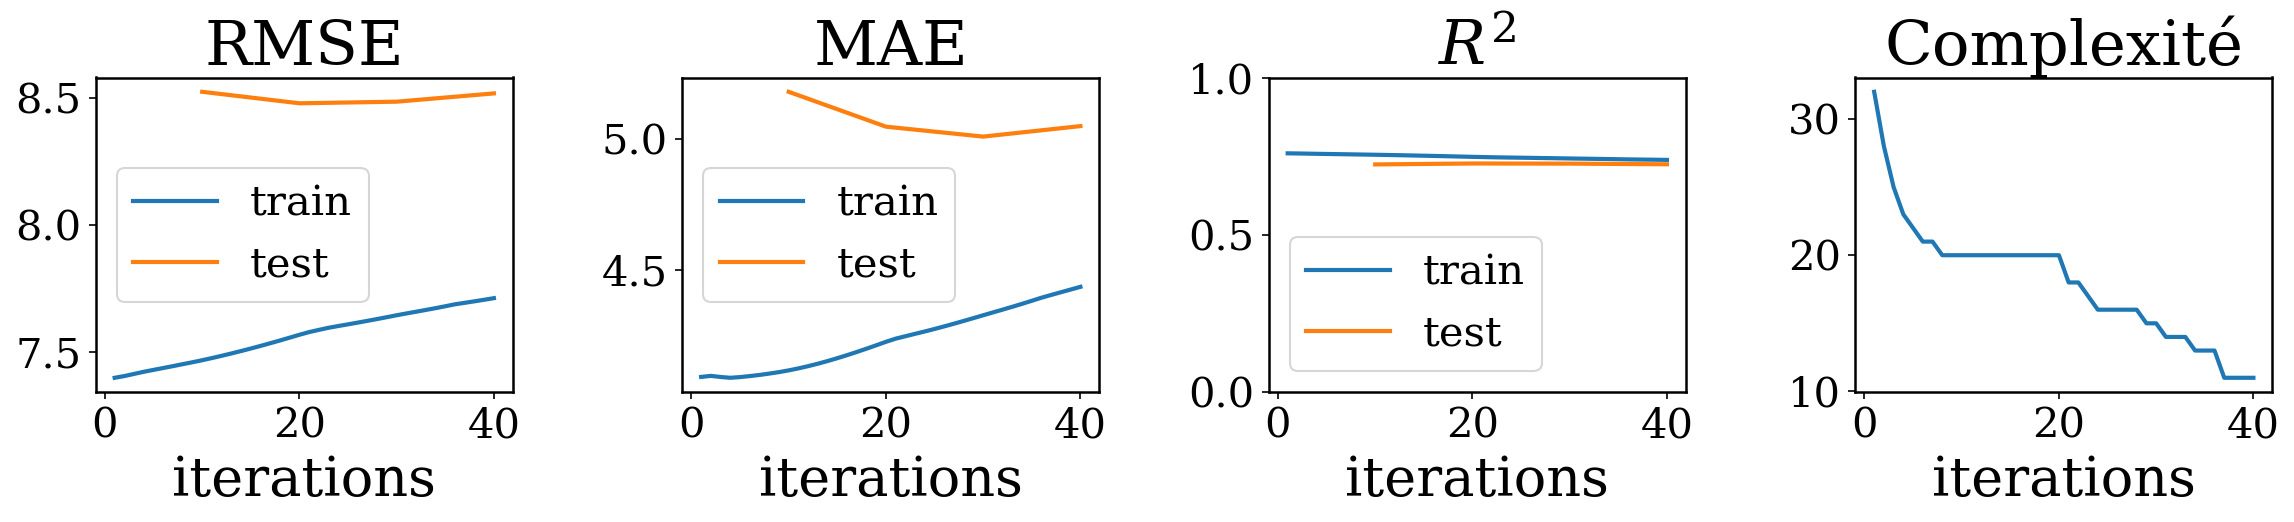

In [10]:
fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])

mae_train = opt_sindy.mae_history
mse_train = opt_sindy.mse_history
r2_train = opt_sindy.r2_history
compl_hist = np.count_nonzero(np.array(opt_sindy.history_), axis=(1, 2))[:-1]

#fig.suptitle(r"Evaluation de PDE-SINDy avec SR3($R=\ell_1$, $\lambda=1$, $\nu=1$)")
iters_complet = np.arange(1, n_iters+1)
ax0 = fig.add_subplot(gs[0])
ax0.plot(sindy_iters_complet, np.sqrt(mse_train), label='train')
ax0.plot(sindy_iters, np.sqrt(MSE_test), label='test')
ax0.legend()
ax0.set_title(r'RMSE')
ax0.set_xlabel('iterations')

ax1 = fig.add_subplot(gs[1])
ax1.plot(sindy_iters_complet, mae_train, label='train')
ax1.plot(sindy_iters, MAE_test, label='test')
ax1.legend()
ax1.set_title(r'MAE')
ax1.set_xlabel('iterations')

ax2 = fig.add_subplot(gs[2])
ax2.plot(sindy_iters_complet, r2_train, label='train')
ax2.plot(sindy_iters, R2_test, label='test')
# ax2.plot(70 * np.log(np.array(opt_sindy.mse_history)) + 2 * compl_hist) 
# ax2.plot(iters, compl, label='complexity')
# ax2.plot(iters, BIC_train, label='Btrain')
# ax2.plot(iters, BIC_test, label='Btest')
ax2.set_title(r'$R^2$')
ax2.set_ylim(0,1)
ax2.legend()
ax2.set_xlabel('iterations')

ax3 = fig.add_subplot(gs[3])
# ax3.plot(iters, AIC_train, label='train')
# ax3.plot(iters, AIC_test, label='test')
ax3.plot(sindy_iters_complet, compl_hist, label='complexity')
# ax2.plot(iters, BIC_train, label='Btrain')
# ax2.plot(iters, BIC_test, label='Btest')
ax3.set_title(r'Complexité')
#ax3.legend()
ax3.set_xlabel('iterations')

fig.tight_layout()

plt.savefig(f'FIGURES/pb{num_pb}_metrics_sindy.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_metrics_sindy.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()




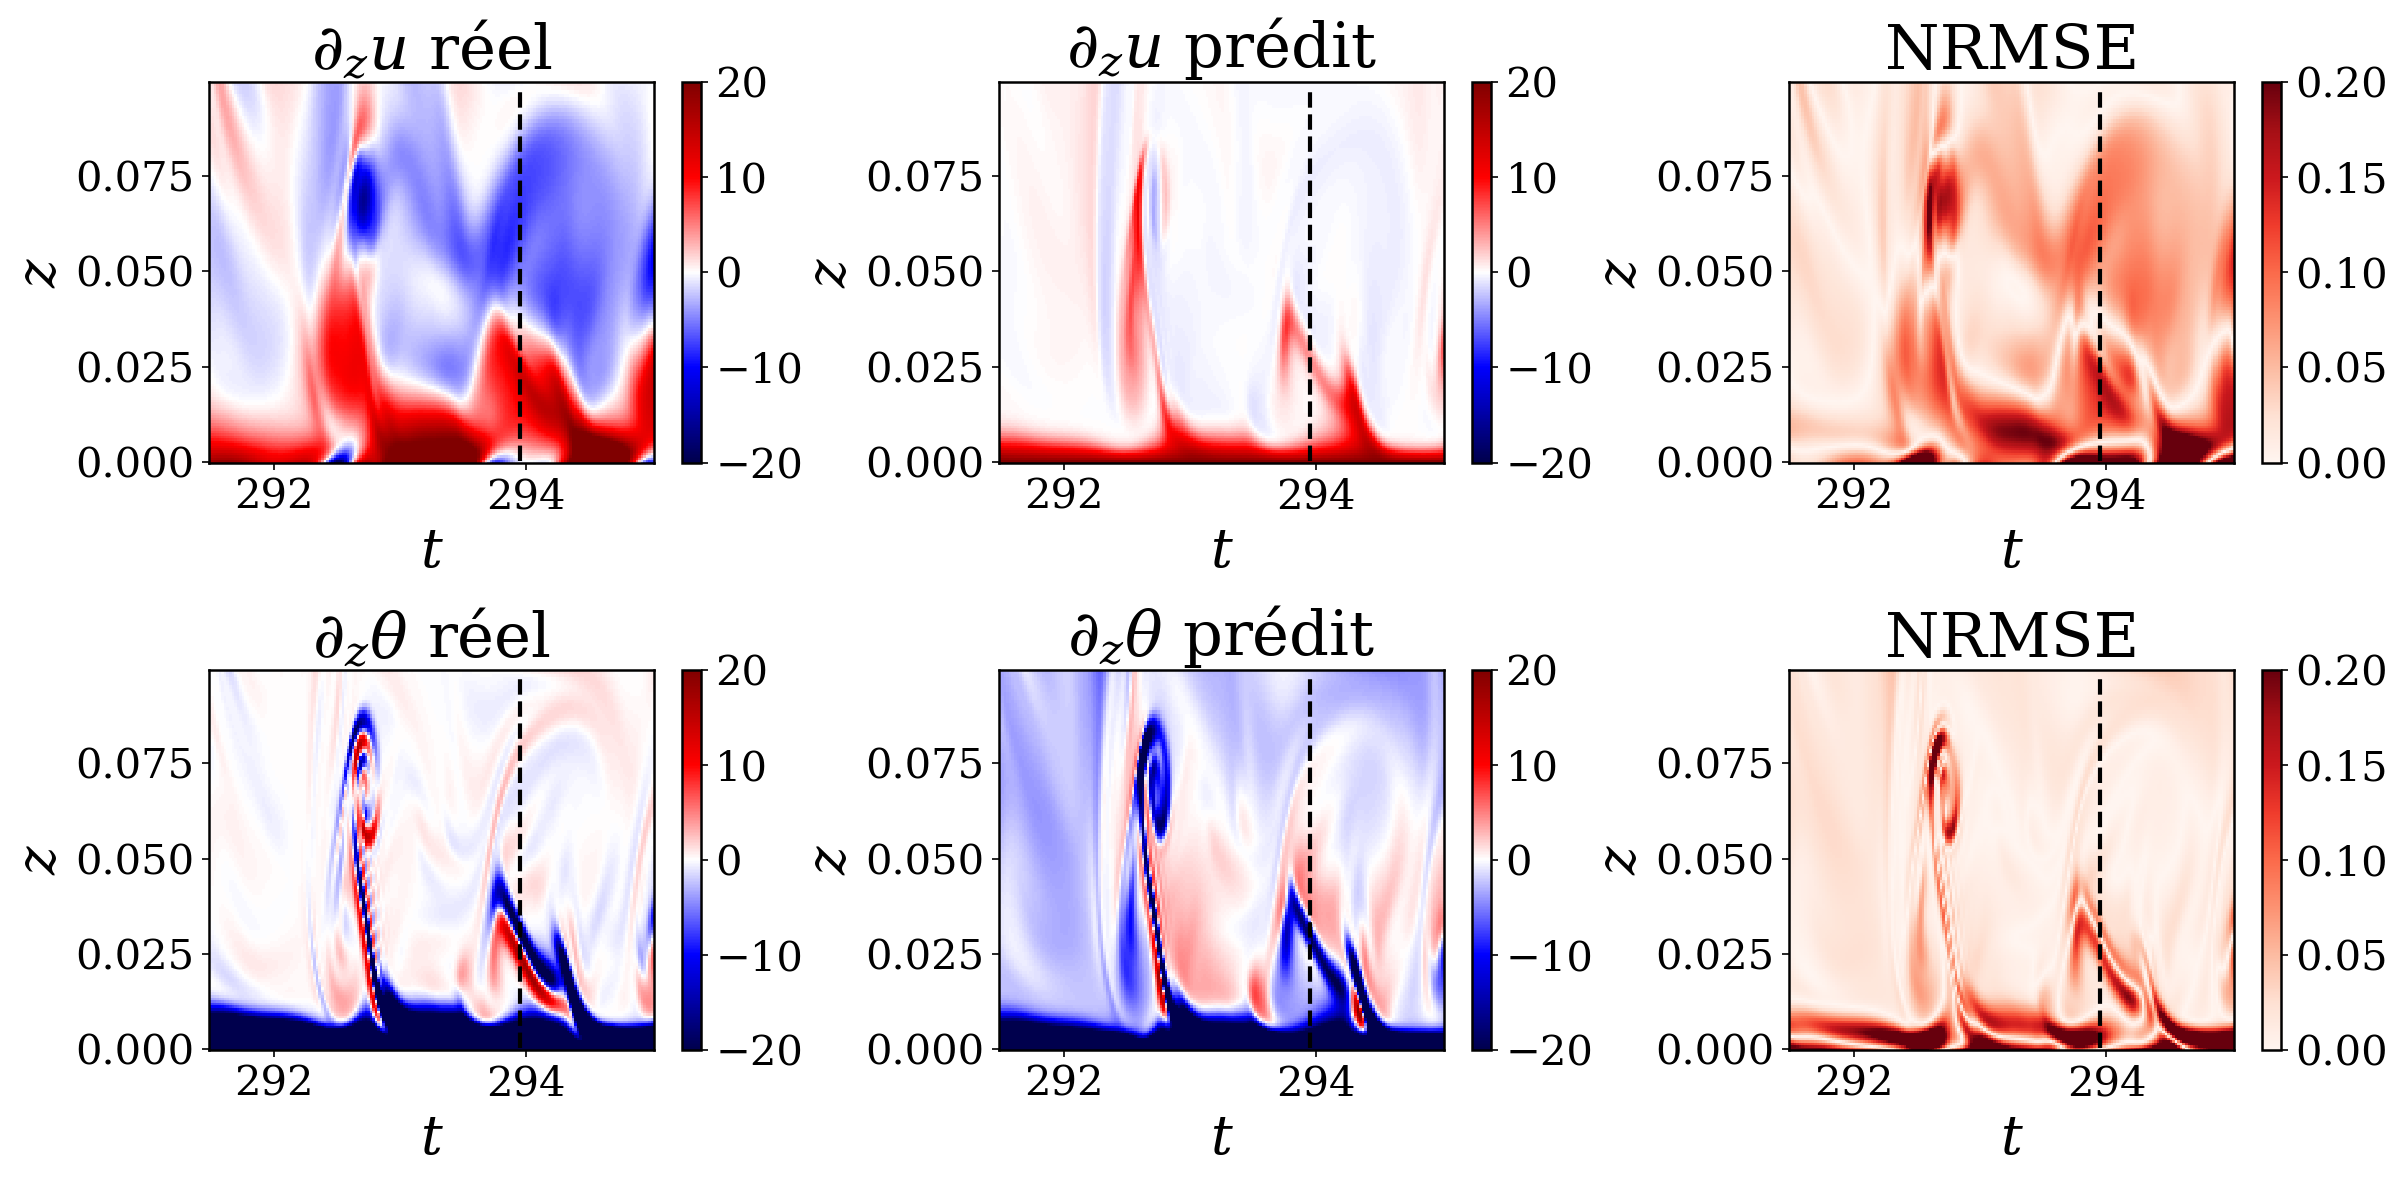

In [85]:
# SINDy

fig = plt.figure( figsize=(16,8))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)

res_norm = mcolors.Normalize(vmin=0.0, vmax=0.2)
norm = mcolors.TwoSlopeNorm(vmin=-20.0, vcenter=0.0, vmax=20.0)
coef = model_sindy.coefficients()
train_transf = pde_lib.fit_transform(X_train)
train_pred = train_transf @ coef.T
test_transf = pde_lib_test.fit_transform(X_test)
test_pred = test_transf @ coef.T
pred_sindy = np.concatenate((train_pred, test_pred), axis=0)


im1 = ax1.pcolor(t, (z), y[:,:,0].T, cmap='seismic', norm=norm)
ax1.vlines(t[train_id[-1]], (z[1]), (z[-2]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r"$\partial_z u$ réel")
ax1.set_ylabel('$z$')
ax1.set_xlabel('$t$')


im2 = ax2.pcolor(t, (z), pred_sindy[:,:,0].T, cmap='seismic', norm=norm)
ax2.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r"$\partial_z u$ prédit")
ax2.set_ylabel('$z$')
ax2.set_xlabel('$t$')


im3 = ax3.pcolor(t, (z), (np.sqrt((y[:,:,0]-pred_sindy[:,:,0])**2)/(y[:,:,0].max() - y[:,:,0].min())).T, cmap='Reds', norm=res_norm)
ax3.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r"NRMSE")
ax3.set_ylabel('$z$')
ax3.set_xlabel('$t$')

im4 = ax4.pcolor(t, (z), y[:,:,1].T, cmap='seismic', norm=norm)
ax4.vlines(t[train_id[-1]], (z[1]), (z[-2]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im4, ax=ax4)
ax4.set_title(r"$\partial_z \theta$ réel")
ax4.set_ylabel('$z$')
ax4.set_xlabel('$t$')


im5 = ax5.pcolor(t, (z), pred_sindy[:,:,1].T, cmap='seismic', norm=norm)
ax5.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im5, ax=ax5)
ax5.set_title(r"$\partial_z \theta$ prédit")
ax5.set_ylabel('$z$')
ax5.set_xlabel('$t$')


im6 = ax6.pcolor(t, (z), (np.sqrt((y[:,:,1]-pred_sindy[:,:,1])**2)/(y[:,:,1].max() - y[:,:,1].min())).T, cmap='Reds', norm=res_norm)
ax6.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im6, ax=ax6)
ax6.set_title(r"NRMSE")
ax6.set_ylabel('$z$')
ax6.set_xlabel('$t$')

fig.tight_layout(pad=0.5)
plt.savefig(f'FIGURES/pb{num_pb}_res_sindy.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_res_sindy.pdf', bbox_inches='tight', transparent=True, backend='pdf')
fig.show()


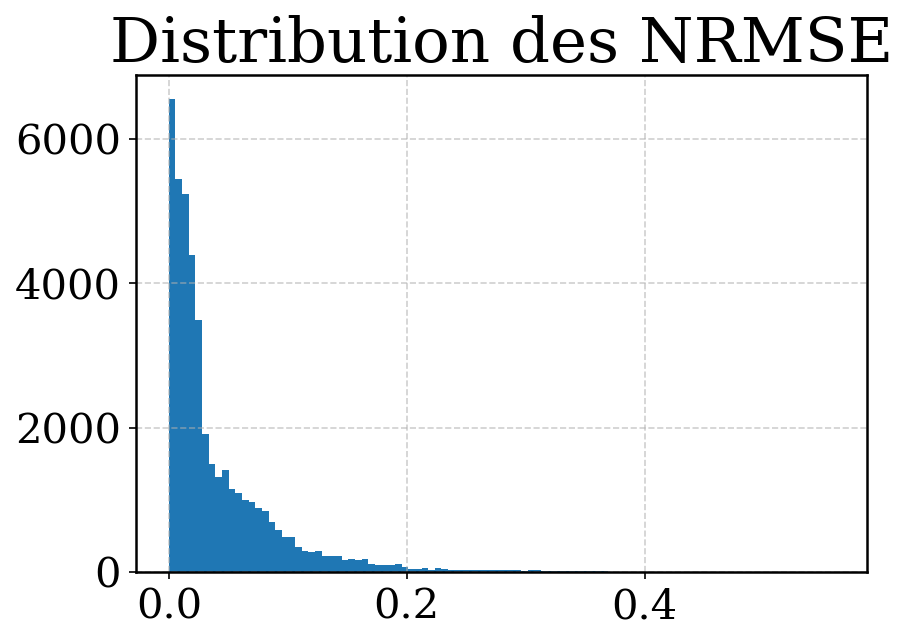

In [12]:

c=0

NRMSE = np.sqrt((y[:,:,:]-pred_sindy[:,:,:])**2)/(y[:,:,:].max(axis=(0,1)) - y[:,:,:].min(axis=(0,1)))
plt.hist(NRMSE.flatten(), bins=100)

plt.title("Distribution des NRMSE")
plt.grid(True)
plt.tight_layout()
plt.savefig(f'FIGURES/pb{num_pb}_nrmse_sindy.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_nrmse_sindy.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()


### KAN

voir le fichier exploration_kan.ipynb, version améliorée de ça 


In [27]:
in_vars=['$u$', '$w$', r'$\theta$', 
        r'$\frac{\partial u}{\partial t}$', 
        r'$\frac{\partial w}{\partial t}$', 
        r'$\frac{\partial \theta}{\partial t}$',  ]
out_vars=[r'$\frac{\partial u}{\partial z}$', 
        r'$\frac{\partial \theta}{\partial z}$']
len(in_vars)
num_pb = 225 # 25 SYMB 

In [39]:
model = kan.KAN(width=[data_kan['test_input'].shape[-1], [1, 0], 2], grid=3, k=3, seed=1501, sparse_init=False)
np.random.seed(1501)
kan_compl = [model.n_edge]
var_imp = []
steps_list = [0, 6, 12, 12]
losses = model.fit(
    data_kan, batch=-1, steps=steps_list[1], loss_fn=torch.nn.MSELoss(),
    update_grid = True, grid_update_num=3,
    lr = 5e-1, lamb=10, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( model.n_edge )

# for i in range(2):
#     model.fix_symbolic(1, 0, i, 'x')
# model.auto_symbolic(lib=['x', 'x^2', '1/x', 'exp', 'log'])


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e+01 | test_loss: 1.69e+01 | reg: 2.21e-01 | : 100%|█| 6/6 [00:04<00:00,  1.41it/s

saving model version 0.1


In [40]:
#model.refine(6)
#model.prune(0.2)
losses2 = model.fit(
    data_kan, batch=-1, steps=steps_list[2], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=1,
    lr = 5e1, lamb=0.1, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( model.n_edge )


model.fix_symbolic(0, 4, 0, 'x^2')
model.fix_symbolic(0, 2, 0, 'exp')
model.fix_symbolic(1, 0, 1, 'exp')
model.auto_symbolic(lib=['x'])


| train_loss: 5.26e+00 | test_loss: 1.06e+01 | reg: 1.71e+01 | : 100%|█| 12/12 [00:08<00:00,  1.45it


saving model version 0.2
r2 is 0.9707657694816589
saving model version 0.3
r2 is 0.9743456244468689
saving model version 0.4
r2 is 0.9830446243286133
saving model version 0.5
fixing (0,0,0) with x, r2=0.8386897444725037, c=1
fixing (0,1,0) with x, r2=0.1492481231689453, c=1
skipping (0,2,0) since already symbolic
fixing (0,3,0) with x, r2=0.34372571110725403, c=1
skipping (0,4,0) since already symbolic
fixing (0,5,0) with x, r2=0.9869912266731262, c=1
fixing (1,0,0) with x, r2=0.2854817509651184, c=1
skipping (1,0,1) since already symbolic
saving model version 0.6


In [41]:


losses3 = model.fit(
    data_kan, batch=-1, steps=steps_list[-1], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=3,
    lr = 5e-2, lamb=.1, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( model.n_edge )

losses_total = {}
for k in losses.keys():
    losses_total[k] = losses[k] + losses2[k] + losses3[k] #+ losses3[k] #+ losses33[k] 
losses_total['r2_score_train'] = 1 - losses_total['mse_loss_train'] / np.mean( (data_kan['train_label']-data_kan['train_label'].mean(axis=[0])).numpy()**2 )
losses_total['r2_score_test'] = 1 - losses_total['mse_loss_test'] / np.mean( (data_kan['test_label']-data_kan['test_label'].mean(axis=[0])).numpy()**2 )


print(r"Modèle KAN pruned avec LBFGS:")
print("     Nombre de coefficients d'apprentissage :", kan_compl[0])
print("     Complexité du modèle :", kan_compl[-1])
print("     R2 score | training : ", losses_total['r2_score_train'][-1], "| testing : ", losses_total['r2_score_test'][-1]) # r2 
print("     MSE score | training : ", losses_total['mse_loss_train'][-1], "| testing : ", losses_total['mse_loss_test'][-1]) # r2
print("     RMSE score | training : ", np.sqrt(losses_total['mse_loss_train'][-1]), "| testing : ", np.sqrt(losses_total['mse_loss_test'][-1])) # r2    
print("     MAE score | training : ", losses_total['l1_loss_train'][-1], "| testing : ",losses_total['l1_loss_test'][-1]) # mse
print('\n\n')


| train_loss: 5.86e+00 | test_loss: 8.74e+00 | reg: 0.00e+00 | : 100%|█| 12/12 [00:10<00:00,  1.19it

saving model version 0.7
Modèle KAN pruned avec LBFGS:
     Nombre de coefficients d'apprentissage : 8
     Complexité du modèle : 0
     R2 score | training :  0.8489481517690067 | testing :  0.7095321932960947
     MSE score | training :  34.28898620605469 | testing :  76.40685272216797
     RMSE score | training :  5.855679824414471 | testing :  8.741101344920327
     MAE score | training :  3.5988314151763916 | testing :  5.378323078155518





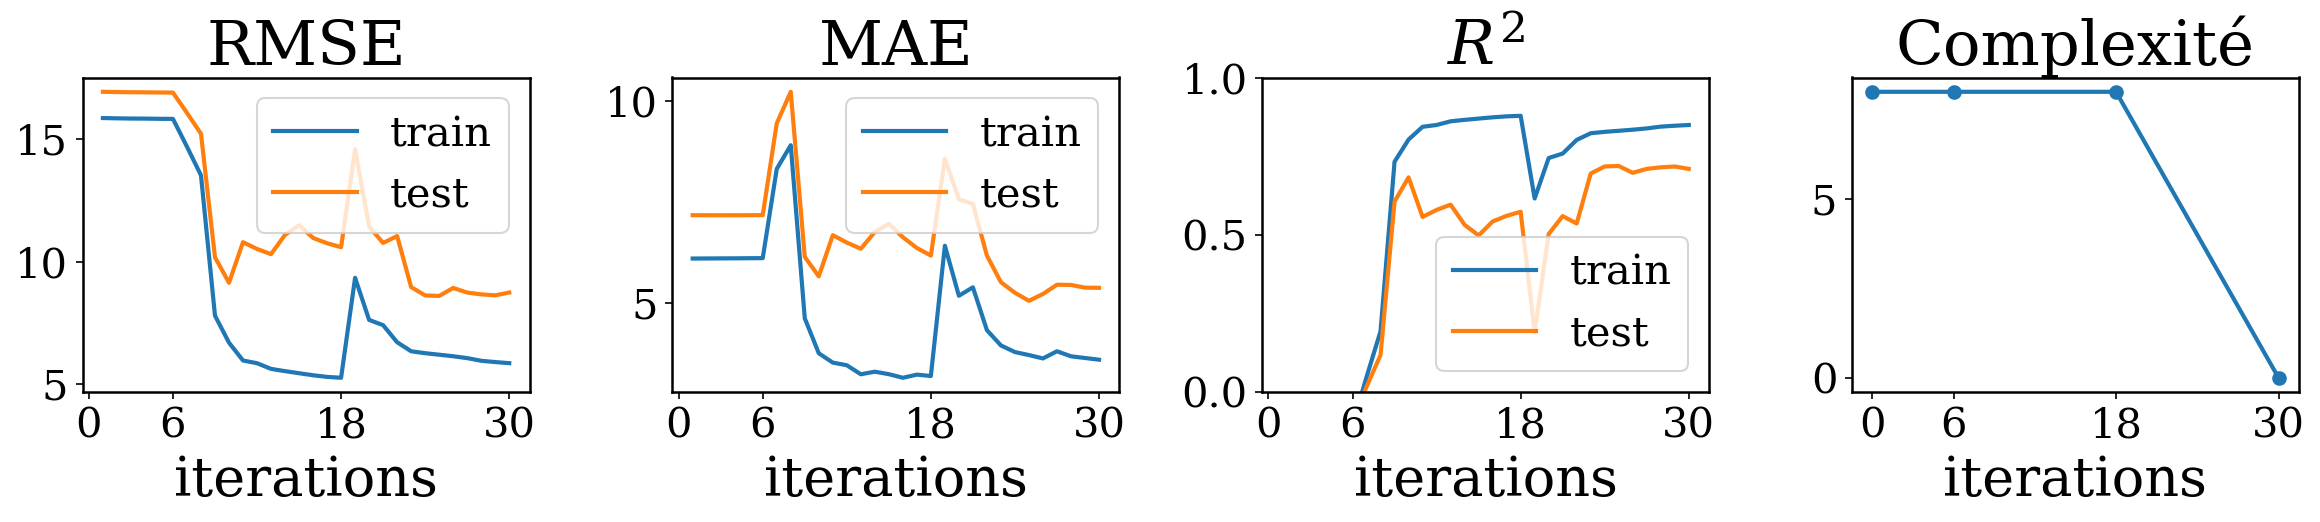

In [50]:

fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])




#fig.suptitle(r"Evaluation de PDE-SINDy avec SR3($R=\ell_1$, $\lambda=1$, $\nu=1$)")
iters = iters_complet = np.arange(1, np.sum(steps_list)+1)
ax0 = fig.add_subplot(gs[0])
ax0.plot(iters_complet, np.sqrt(losses_total['mse_loss_train']), label='train')
ax0.plot(iters, np.sqrt(losses_total['mse_loss_test']), label='test')
ax0.legend()
ax0.set_title(r'RMSE')
ax0.set_xlabel('iterations')
ax0.set_xticks(np.cumsum(steps_list))

ax1 = fig.add_subplot(gs[1])
ax1.plot(iters_complet, losses_total['l1_loss_train'], label='train')
ax1.plot(iters, losses_total['l1_loss_test'], label='test')
ax1.legend()
ax1.set_title(r'MAE')
ax1.set_xlabel('iterations')
ax1.set_xticks(np.cumsum(steps_list))

ax2 = fig.add_subplot(gs[2])
ax2.plot(iters_complet, losses_total['r2_score_train'] , label='train')
ax2.plot(iters, losses_total['r2_score_test'] , label='test')
ax2.set_title(r'$R^2$')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_xlabel('iterations')
ax2.set_xticks(np.cumsum(steps_list))

ax3 = fig.add_subplot(gs[3])
ax3.plot(np.cumsum(steps_list), kan_compl, label='complexity', marker='o')
ax3.set_xticks(np.cumsum(steps_list))
ax3.set_title(r'Complexité')
ax3.set_xlabel('iterations')

fig.tight_layout()

plt.savefig(f'FIGURES/pb{num_pb}_metrics_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_metrics_kan.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()




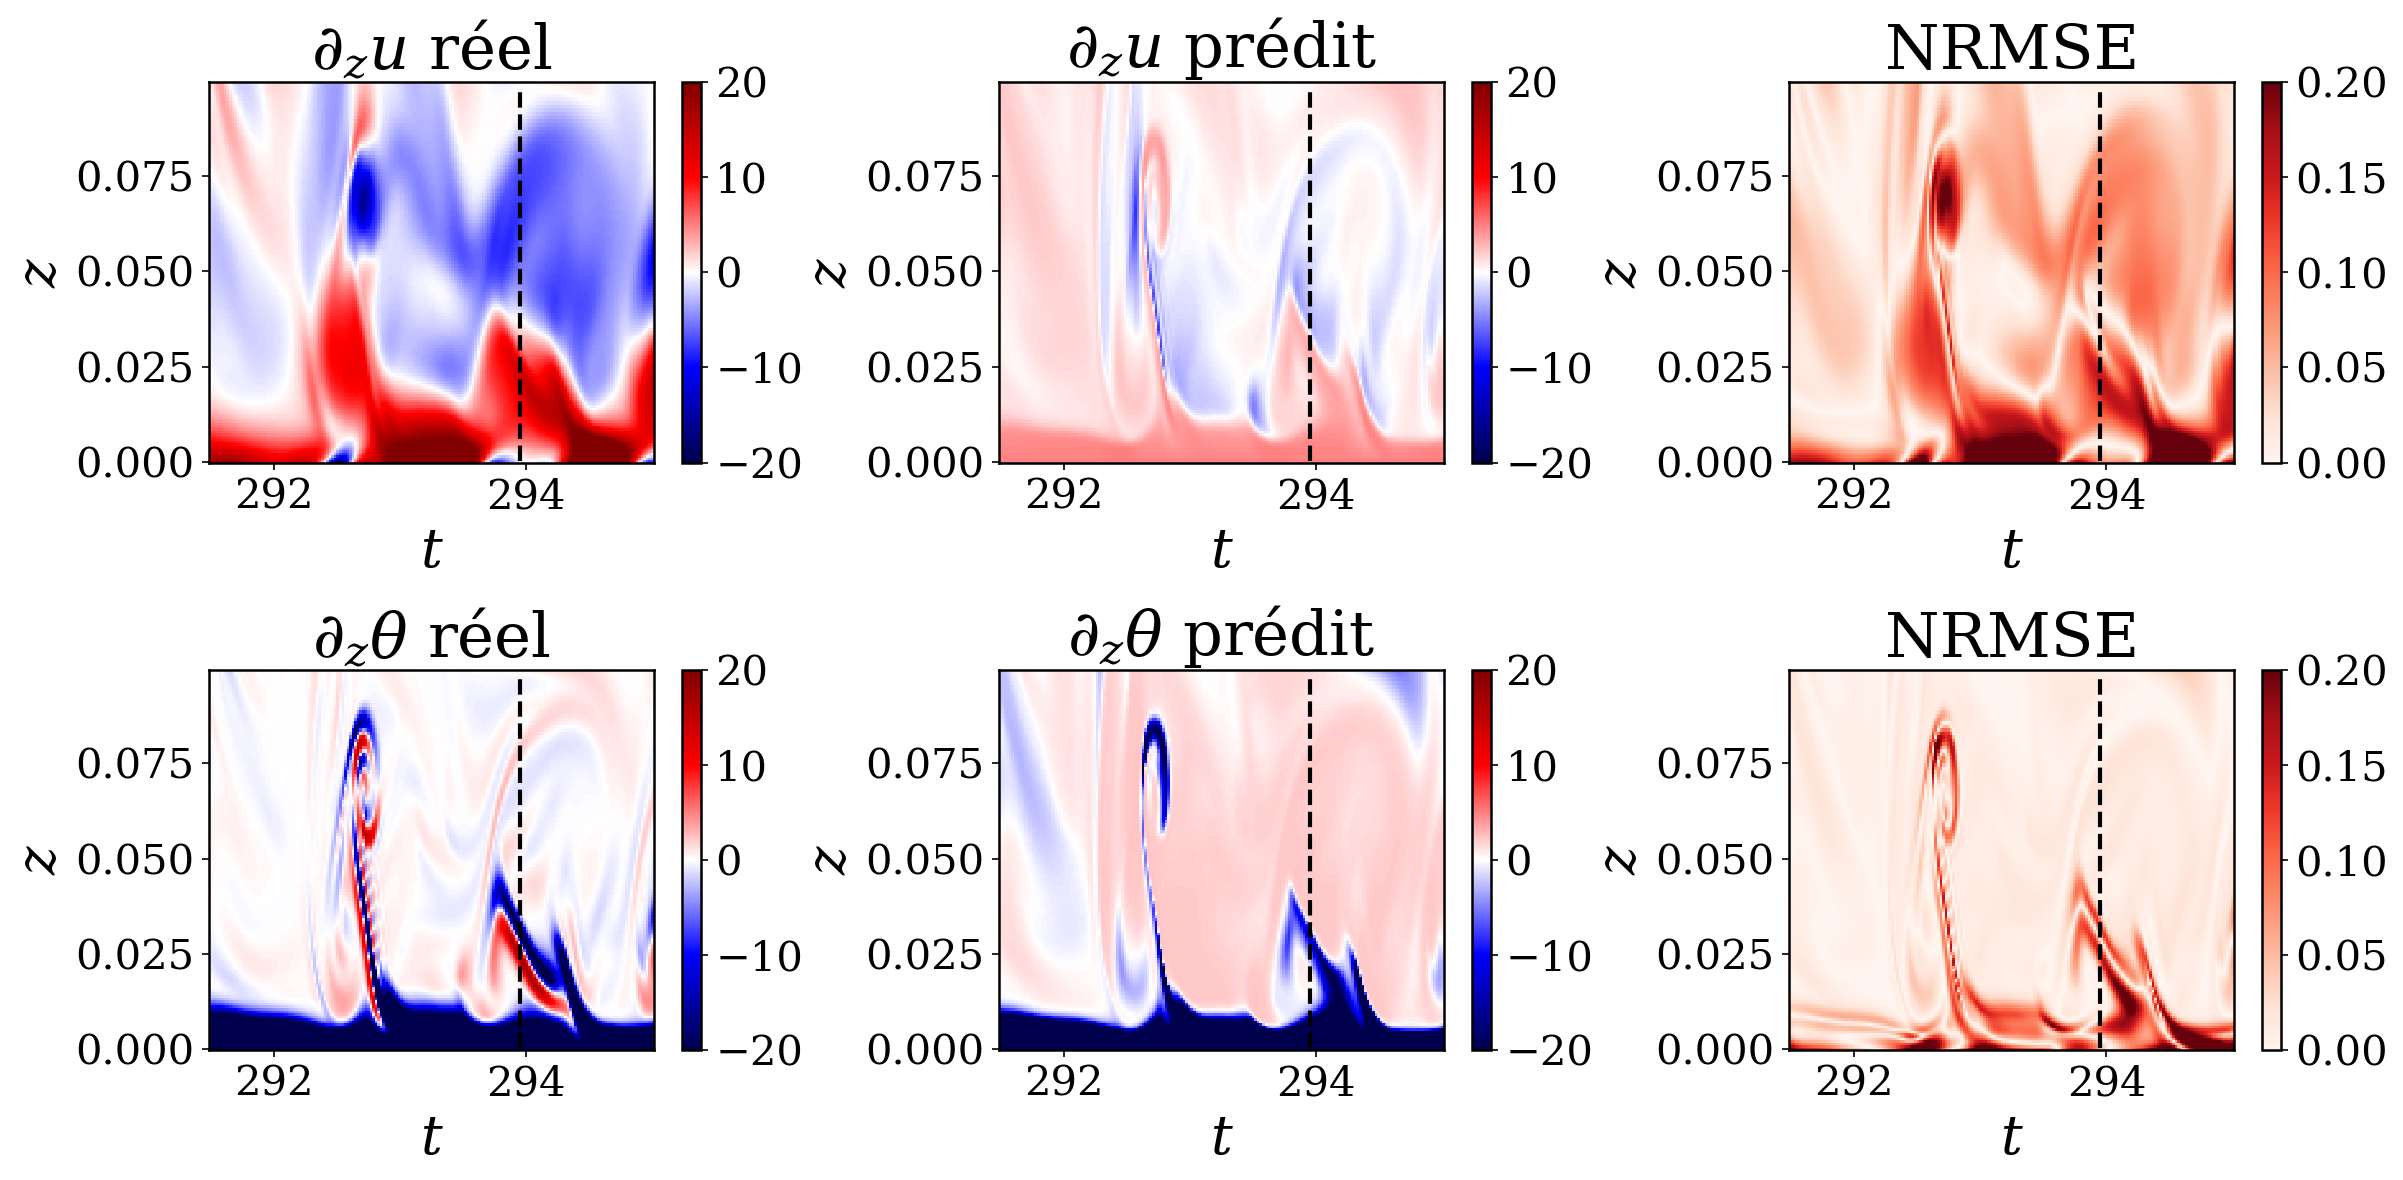

In [51]:
# SINDy

fig = plt.figure( figsize=(16,8))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)

res_norm = mcolors.Normalize(vmin=0.0, vmax=0.2)
norm = mcolors.TwoSlopeNorm(vmin=-20.0, vcenter=0.0, vmax=20.0)
# coeff_weak = model_weak.coefficients()
# pred_sindy = (X_transf @ coeff_weak.T)[:,:,[0,2]]

pred_train = model(data_kan['train_input']).detach().numpy().reshape(len(t_train), len(z), 2)
pred_test = model(data_kan['test_input']).detach().numpy().reshape(len(t_test),len(z), 2)
pred = np.concatenate((pred_train, pred_test), axis=0) 
pred_sindy = pred # unormalize(torch.from_numpy(pred), mean_y_kan, std_y_kan).detach().numpy()

# data_input = torch.concatenate([data_kan['train_input'], data_kan['test_input']], dim=0)
# pred_sindy = model(data_input).detach().numpy().reshape(len(z), len(t), 2)

im1 = ax1.pcolor(t, (z), y[:,:,0].T, cmap='seismic', norm=norm)
ax1.vlines(t[train_id[-1]], (z[1]), (z[-2]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r"$\partial_z u$ réel")
ax1.set_ylabel('$z$')
ax1.set_xlabel('$t$')


im2 = ax2.pcolor(t, (z), pred_sindy[:,:,0].T, cmap='seismic', norm=norm)
ax2.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r"$\partial_z u$ prédit")
ax2.set_ylabel('$z$')
ax2.set_xlabel('$t$')


im3 = ax3.pcolor(t, (z), (np.sqrt((y[:,:,0]-pred_sindy[:,:,0])**2)/(y[:,:,0].max() - y[:,:,0].min())).T, cmap='Reds', norm=res_norm)
ax3.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r"NRMSE")
ax3.set_ylabel('$z$')
ax3.set_xlabel('$t$')

im4 = ax4.pcolor(t, (z), y[:,:,1].T, cmap='seismic', norm=norm)
ax4.vlines(t[train_id[-1]], (z[1]), (z[-2]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im4, ax=ax4)
ax4.set_title(r"$\partial_z \theta$ réel")
ax4.set_ylabel('$z$')
ax4.set_xlabel('$t$')


im5 = ax5.pcolor(t, (z), pred_sindy[:,:,1].T, cmap='seismic', norm=norm)
ax5.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im5, ax=ax5)
ax5.set_title(r"$\partial_z \theta$ prédit")
ax5.set_ylabel('$z$')
ax5.set_xlabel('$t$')


im6 = ax6.pcolor(t, (z), (np.sqrt((y[:,:,1]-pred_sindy[:,:,1])**2)/(y[:,:,1].max() - y[:,:,1].min())).T, cmap='Reds', norm=res_norm)
ax6.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im6, ax=ax6)
ax6.set_title(r"NRMSE")
ax6.set_ylabel('$z$')
ax6.set_xlabel('$t$')

fig.tight_layout(pad=0.5)
plt.savefig(f'FIGURES/pb{num_pb}_res_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_res_kan.pdf', bbox_inches='tight', transparent=True, backend='pdf')
fig.show()


In [44]:
num_pb

225

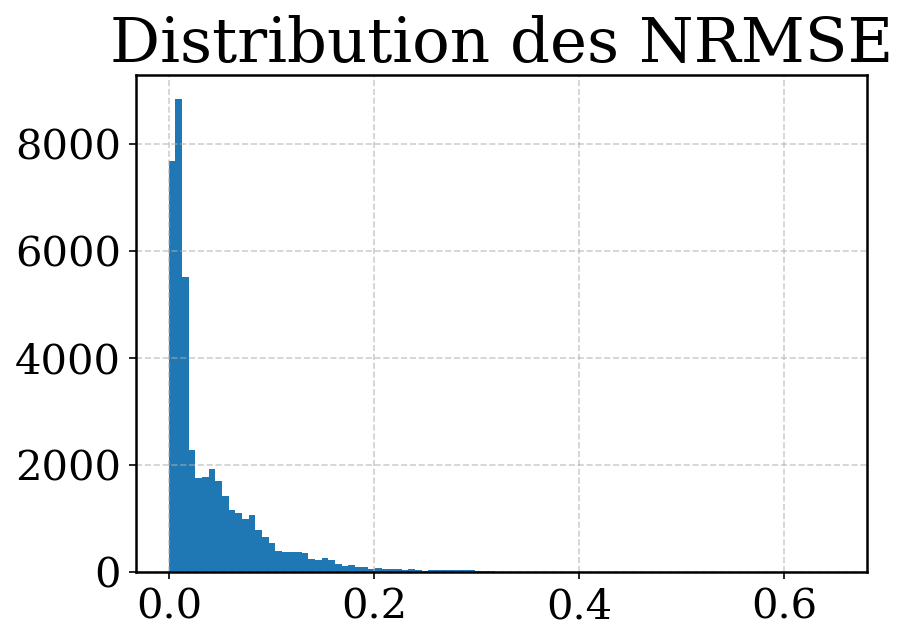

In [52]:


NRMSE = np.sqrt((y[:,:,:]-pred_sindy[:,:,:])**2)/(y[:,:,:].max(axis=(0, 1)) - y[:,:,:].min(axis=(0, 1)))
plt.hist(NRMSE.flatten(), bins=100)

plt.title("Distribution des NRMSE")
plt.tight_layout()
plt.grid(True)
plt.savefig(f'FIGURES/pb{num_pb}_nrmse_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_nrmse_kan.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()


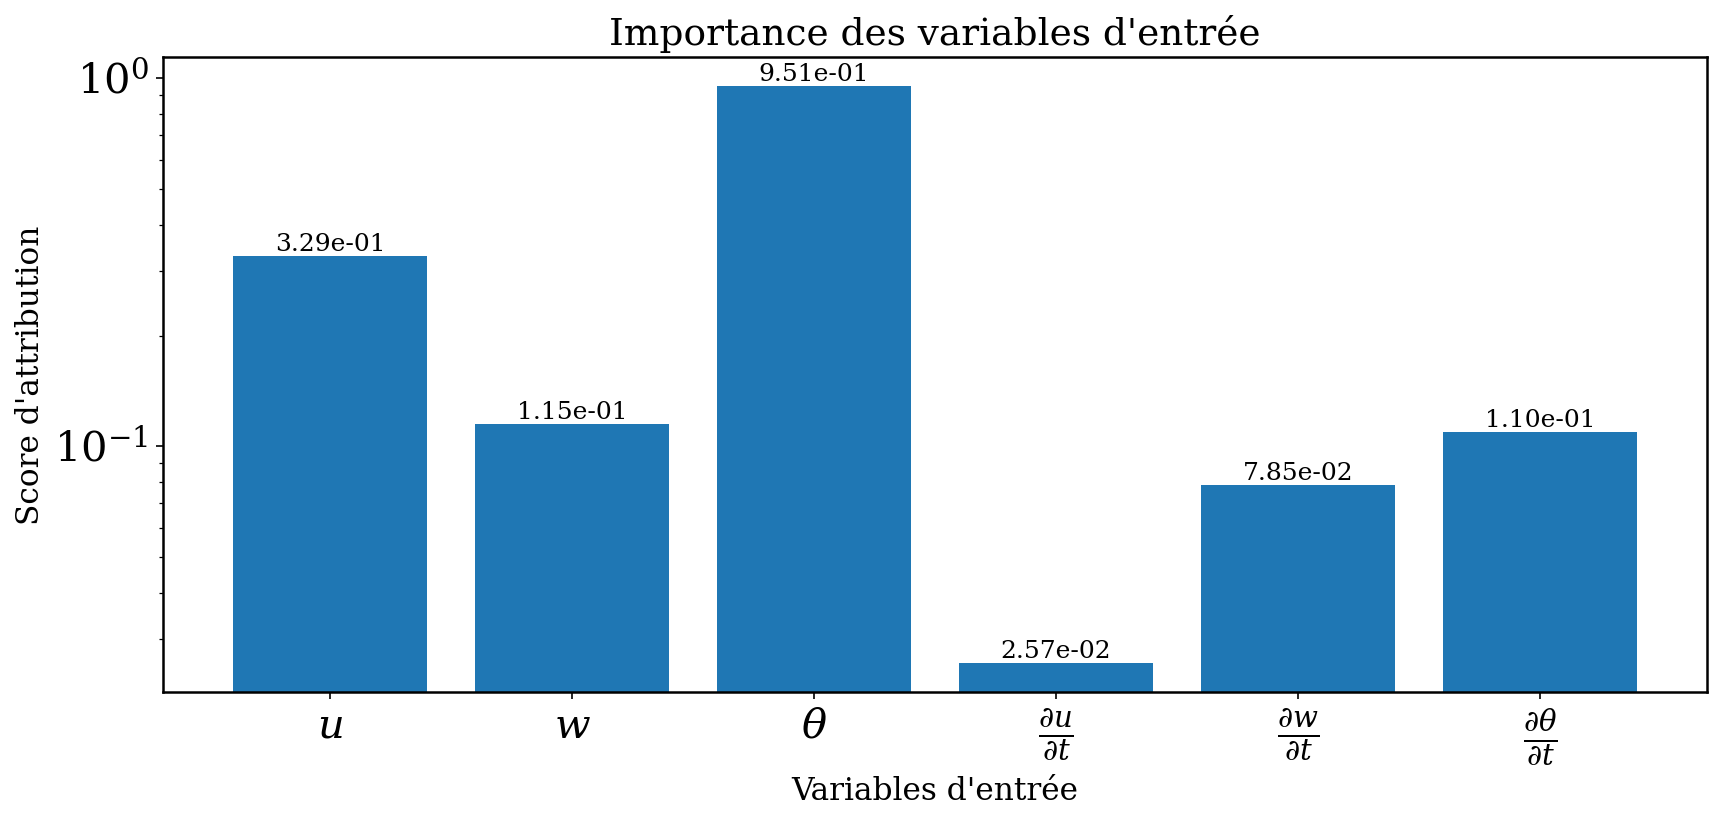

In [53]:
import numpy as np
import matplotlib.pyplot as plt

scores = model.feature_score.cpu().detach().numpy()
features = in_vars  # liste des noms des features

plt.figure(figsize=(12, 6))
bars = plt.bar(features, scores, color='tab:blue')

plt.yscale('log')
plt.xlabel('Variables d\'entrée', fontsize=15)
plt.ylabel('Score d\'attribution', fontsize=15)
plt.title("Importance des variables d'entrée", fontsize=18)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Optionnel : ajouter les valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height * 1.0,
             f'{height:.2e}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.grid(False)
plt.savefig(f'FIGURES/pb{num_pb}_varimp_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_varimp_kan.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()


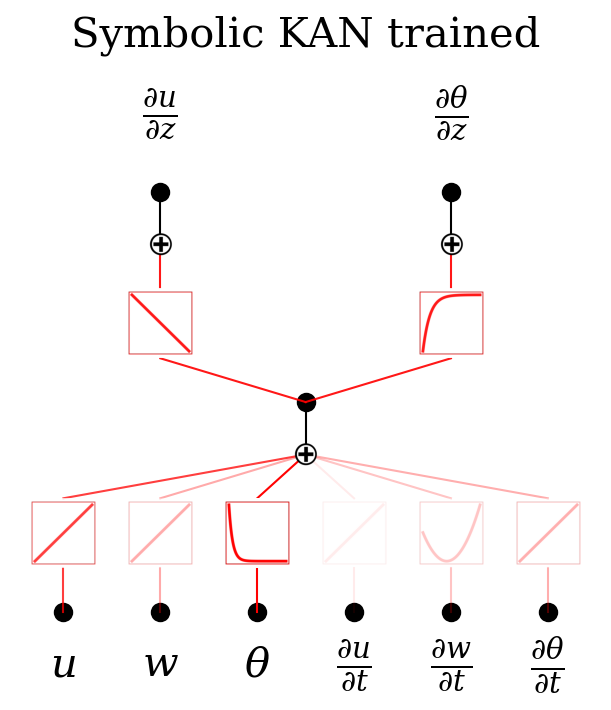

In [47]:
model.plot(in_vars=in_vars, out_vars=out_vars, title='Symbolic KAN trained', folder= './FIGKAN/') # mettre juste 3 node addition 

In [48]:
kan.ex_round(model.symbolic_formula()[0][0], 3)

-0.509*x_1 - 0.201*x_2 - 0.051*x_4 - 0.164*x_6 - 0.187*(-x_5 - 0.384)**2 + 4.169 - 1.274*exp(-2.985*x_3)

In [49]:
kan.ex_round(model.symbolic_formula()[0][1], 3)

2.198 - 41.367*exp(-0.523*x_1 - 0.207*x_2 - 0.053*x_4 - 0.168*x_6 - 0.192*(-x_5 - 0.384)**2 - 1.31*exp(-2.985*x_3))

In [54]:
num_pb

225

In [14]:

# Pour le juste élagué
num_pb = 2223

np.random.seed(1501)
model = kan.KAN(width=[data_kan['test_input'].shape[-1], [3, 2], 2], grid=3, k=3, seed=1501, sparse_init=False)
kan_compl = [9*5 + 5*2]
var_imp = []
steps_list = [0, 6, 12, 12]
losses = model.fit(
    data_kan, batch=-1, steps=steps_list[1], loss_fn=torch.nn.MSELoss(),
    update_grid = True, grid_update_num=3,
    lr = 5e-1, lamb=10, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( model.n_edge )
#model.refine(6)
model.prune(0.3)
losses2 = model.fit(
    data_kan, batch=-1, steps=steps_list[2], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=1,
    lr = 5e1, lamb=0.1, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append(  model.n_edge )

model.prune(0.3)
losses3 = model.fit(
    data_kan, batch=-1, steps=steps_list[3], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=3,
    lr = 5e-2, lamb=0.1, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append(  model.n_edge )

losses_total = {}
for k in losses.keys():
    losses_total[k] = losses[k] + losses2[k] + losses3[k] #+ losses33[k] 
losses_total['r2_score_train'] = 1 - losses_total['mse_loss_train'] / np.mean( (data_kan['train_label']-data_kan['train_label'].mean(axis=[0])).numpy()**2 )
losses_total['r2_score_test'] = 1 - losses_total['mse_loss_test'] / np.mean( (data_kan['test_label']-data_kan['test_label'].mean(axis=[0])).numpy()**2 )


print(r"Modèle KAN pruned avec LBFGS:")
print("     Nombre de coefficients d'apprentissage :", kan_compl[0])
print("     Complexité du modèle :", kan_compl[-1])
print("     R2 score | training : ", losses_total['r2_score_train'][-1], "| testing : ", losses_total['r2_score_test'][-1]) # r2 
print("     MSE score | training : ", losses_total['mse_loss_train'][-1], "| testing : ", losses_total['mse_loss_test'][-1]) # r2
print("     RMSE score | training : ", np.sqrt(losses_total['mse_loss_train'][-1]), "| testing : ", np.sqrt(losses_total['mse_loss_test'][-1])) # r2    
print("     MAE score | training : ", losses_total['l1_loss_train'][-1], "| testing : ",losses_total['l1_loss_test'][-1]) # mse
print('\n\n')


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e+01 | test_loss: 1.69e+01 | reg: 6.45e-01 | : 100%|█| 6/6 [00:09<00:00,  1.54s/it


saving model version 0.1
saving model version 0.2


| train_loss: 5.15e+00 | test_loss: 9.56e+00 | reg: 1.32e+01 | : 100%|█| 12/12 [00:18<00:00,  1.57s/


saving model version 0.2
saving model version 0.3


| train_loss: 4.87e+00 | test_loss: 8.33e+00 | reg: 1.39e+01 | : 100%|█| 12/12 [00:17<00:00,  1.50s/

saving model version 0.3
Modèle KAN pruned avec LBFGS:
     Nombre de coefficients d'apprentissage : 55
     Complexité du modèle : 8
     R2 score | training :  0.8953190750597274 | testing :  0.7362429771508767
     MSE score | training :  23.762720108032227 | testing :  69.38064575195312
     RMSE score | training :  4.874702053257432 | testing :  8.329504532200767
     MAE score | training :  2.8335702419281006 | testing :  4.955772876739502





23


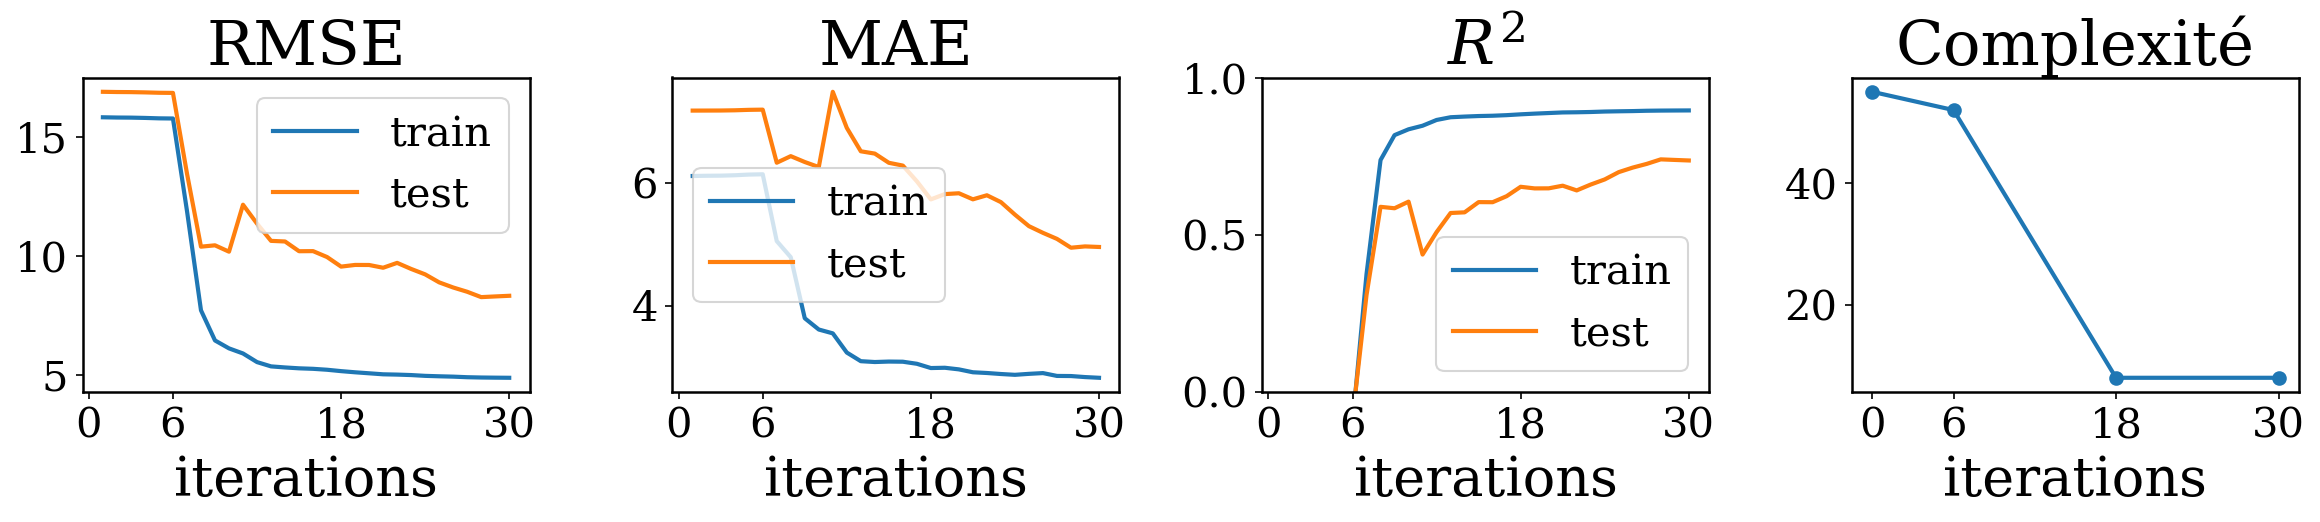

In [15]:
num_pb=23
print(num_pb)
fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])




#fig.suptitle(r"Evaluation de PDE-SINDy avec SR3($R=\ell_1$, $\lambda=1$, $\nu=1$)")
iters = iters_complet = np.arange(1, np.sum(steps_list)+1)
ax0 = fig.add_subplot(gs[0])
ax0.plot(iters_complet, np.sqrt(losses_total['mse_loss_train']), label='train')
ax0.plot(iters, np.sqrt(losses_total['mse_loss_test']), label='test')
ax0.legend()
ax0.set_title(r'RMSE')
ax0.set_xlabel('iterations')
ax0.set_xticks(np.cumsum(steps_list))

ax1 = fig.add_subplot(gs[1])
ax1.plot(iters_complet, losses_total['l1_loss_train'], label='train')
ax1.plot(iters, losses_total['l1_loss_test'], label='test')
ax1.legend()
ax1.set_title(r'MAE')
ax1.set_xlabel('iterations')
ax1.set_xticks(np.cumsum(steps_list))

ax2 = fig.add_subplot(gs[2])
ax2.plot(iters_complet, losses_total['r2_score_train'] , label='train')
ax2.plot(iters, losses_total['r2_score_test'] , label='test')
ax2.set_title(r'$R^2$')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_xlabel('iterations')
ax2.set_xticks(np.cumsum(steps_list))

ax3 = fig.add_subplot(gs[3])
ax3.plot(np.cumsum(steps_list), kan_compl, label='complexity', marker='o')
ax3.set_xticks(np.cumsum(steps_list))
ax3.set_title(r'Complexité')
ax3.set_xlabel('iterations')

fig.tight_layout()

plt.savefig(f'FIGURES/pb{num_pb}_metrics_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_metrics_kan.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()




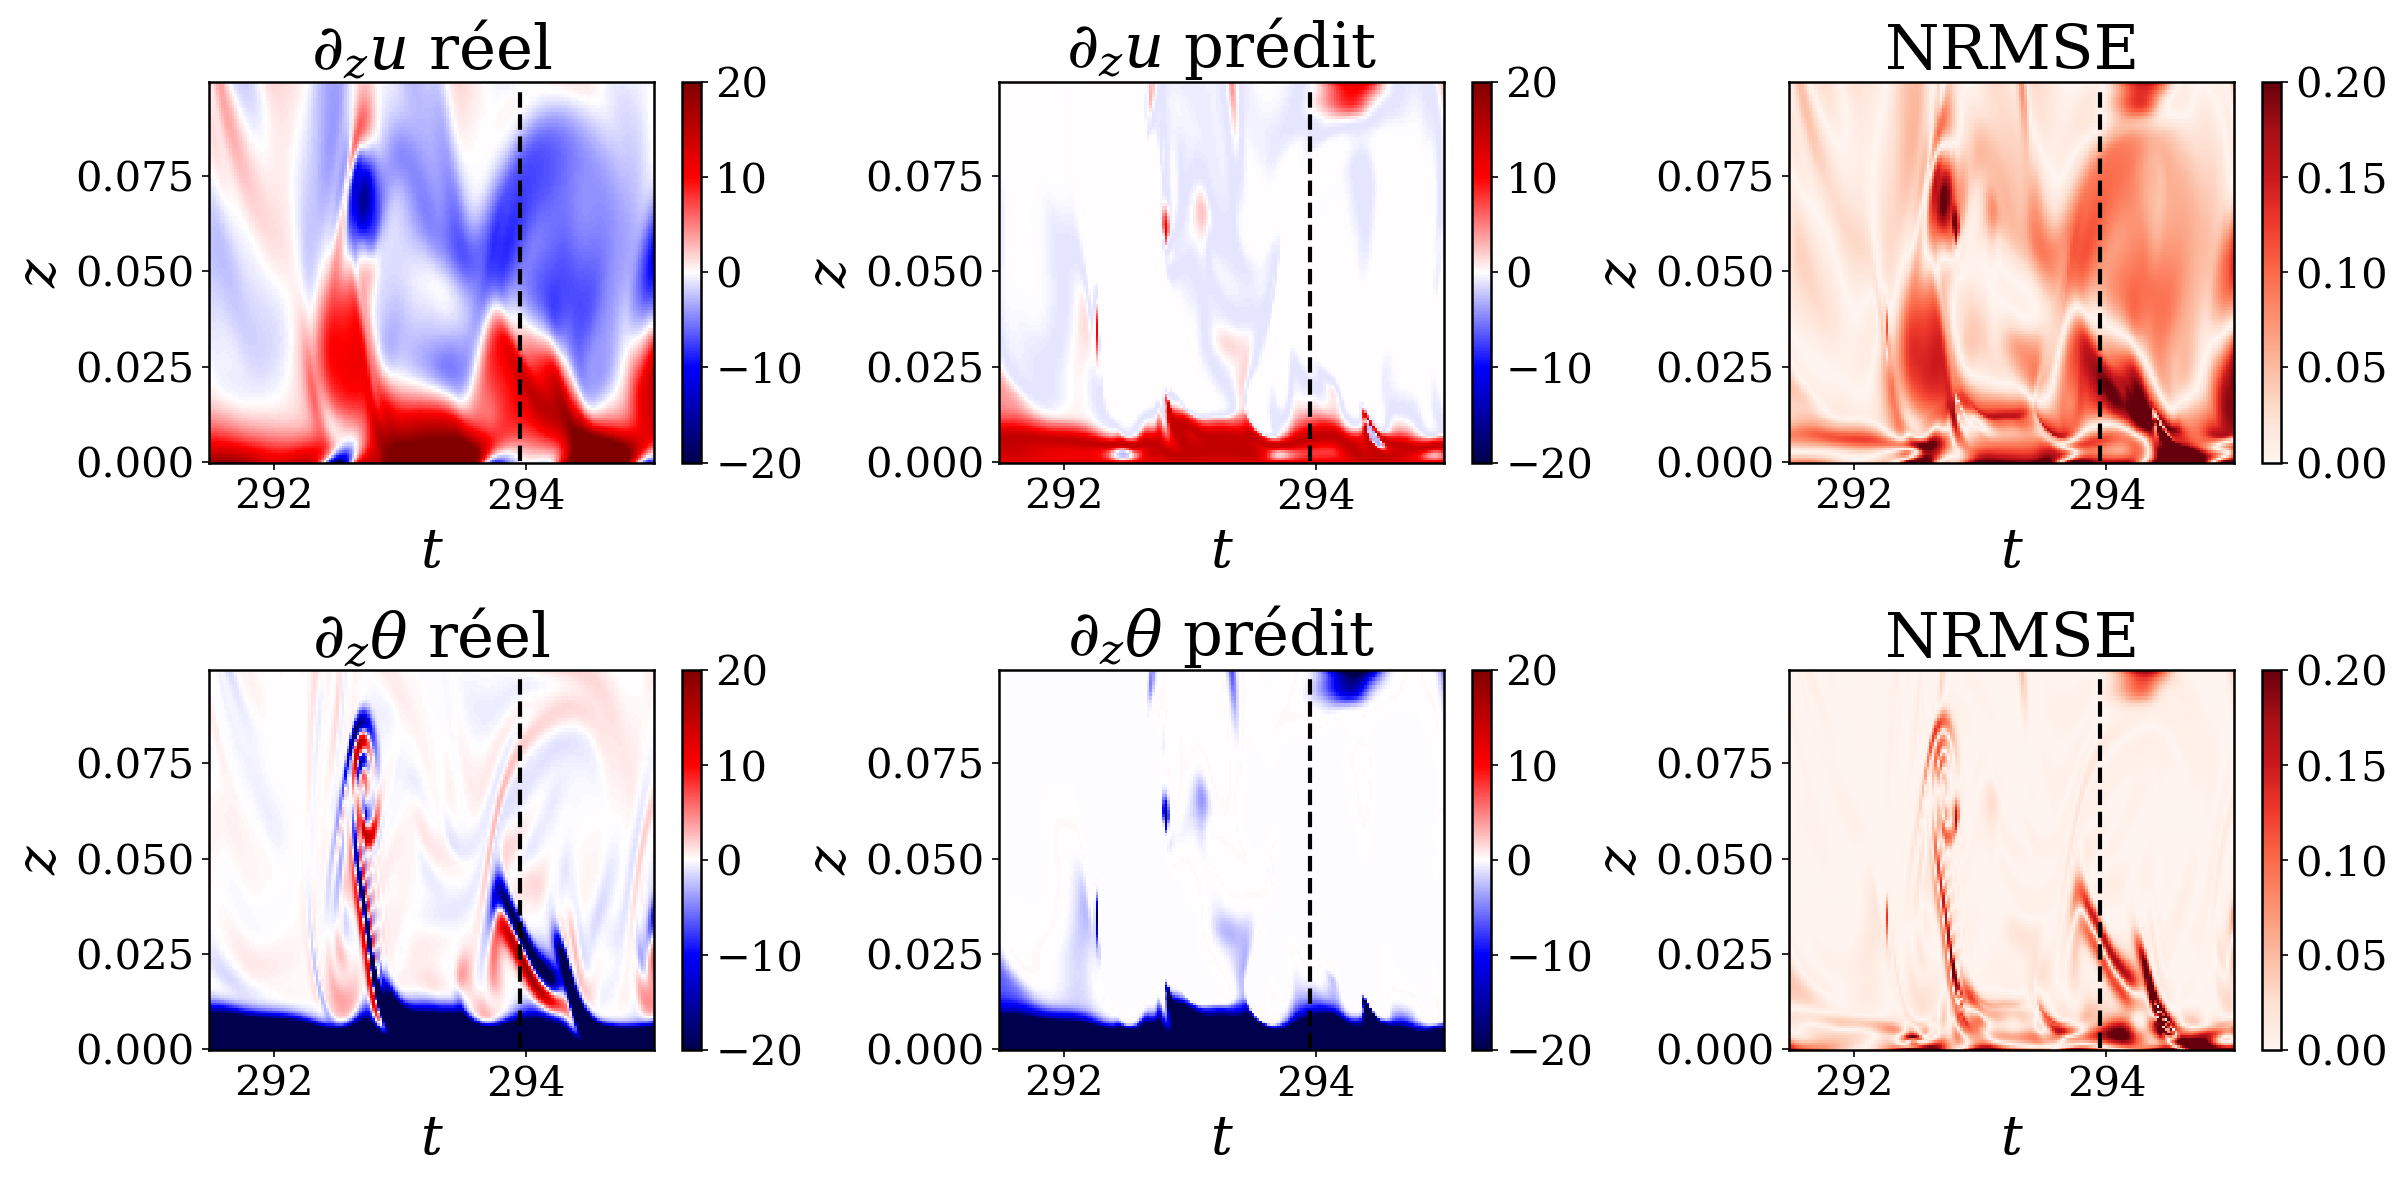

In [16]:
# SINDy

fig = plt.figure( figsize=(16,8))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)

res_norm = mcolors.Normalize(vmin=0.0, vmax=0.2)
norm = mcolors.TwoSlopeNorm(vmin=-20.0, vcenter=0.0, vmax=20.0)
# coeff_weak = model_weak.coefficients()
# pred_sindy = (X_transf @ coeff_weak.T)[:,:,[0,2]]

pred_train = model(data_kan['train_input']).detach().numpy().reshape(len(t_train), len(z), 2)
pred_test = model(data_kan['test_input']).detach().numpy().reshape(len(t_test),len(z), 2)
pred = np.concatenate((pred_train, pred_test), axis=0) 
pred_sindy = pred # unormalize(torch.from_numpy(pred), mean_y_kan, std_y_kan).detach().numpy()

# data_input = torch.concatenate([data_kan['train_input'], data_kan['test_input']], dim=0)
# pred_sindy = model(data_input).detach().numpy().reshape(len(z), len(t), 2)

im1 = ax1.pcolor(t, (z), y[:,:,0].T, cmap='seismic', norm=norm)
ax1.vlines(t[train_id[-1]], (z[1]), (z[-2]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r"$\partial_z u$ réel")
ax1.set_ylabel('$z$')
ax1.set_xlabel('$t$')


im2 = ax2.pcolor(t, (z), pred_sindy[:,:,0].T, cmap='seismic', norm=norm)
ax2.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r"$\partial_z u$ prédit")
ax2.set_ylabel('$z$')
ax2.set_xlabel('$t$')


im3 = ax3.pcolor(t, (z), (np.sqrt((y[:,:,0]-pred_sindy[:,:,0])**2)/(y[:,:,0].max() - y[:,:,0].min())).T, cmap='Reds', norm=res_norm)
ax3.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r"NRMSE")
ax3.set_ylabel('$z$')
ax3.set_xlabel('$t$')

im4 = ax4.pcolor(t, (z), y[:,:,1].T, cmap='seismic', norm=norm)
ax4.vlines(t[train_id[-1]], (z[1]), (z[-2]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im4, ax=ax4)
ax4.set_title(r"$\partial_z \theta$ réel")
ax4.set_ylabel('$z$')
ax4.set_xlabel('$t$')


im5 = ax5.pcolor(t, (z), pred_sindy[:,:,1].T, cmap='seismic', norm=norm)
ax5.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im5, ax=ax5)
ax5.set_title(r"$\partial_z \theta$ prédit")
ax5.set_ylabel('$z$')
ax5.set_xlabel('$t$')


im6 = ax6.pcolor(t, (z), (np.sqrt((y[:,:,1]-pred_sindy[:,:,1])**2)/(y[:,:,1].max() - y[:,:,1].min())).T, cmap='Reds', norm=res_norm)
ax6.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im6, ax=ax6)
ax6.set_title(r"NRMSE")
ax6.set_ylabel('$z$')
ax6.set_xlabel('$t$')

fig.tight_layout(pad=0.5)
plt.savefig(f'FIGURES/pb{num_pb}_res_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_res_kan.pdf', bbox_inches='tight', transparent=True, backend='pdf')
fig.show()


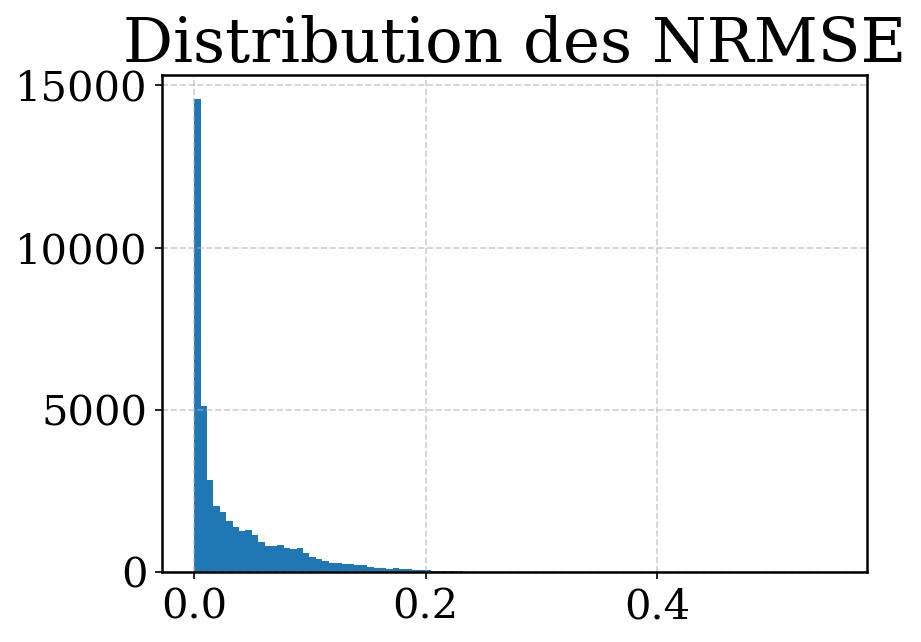

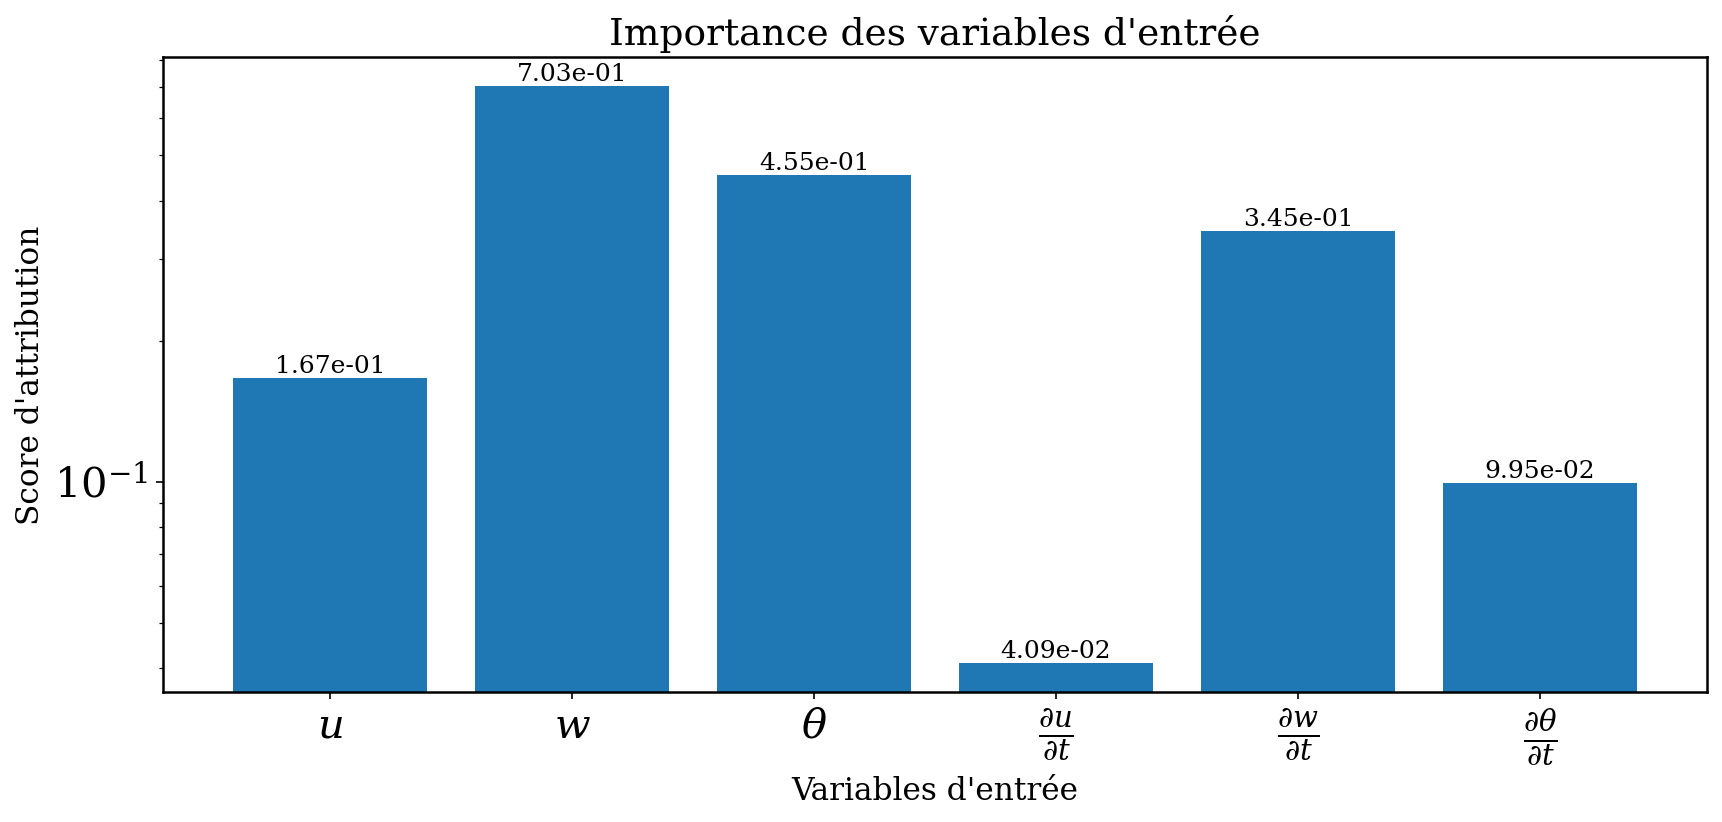

In [17]:


NRMSE = np.sqrt((y[:,:,:]-pred_sindy[:,:,:])**2)/(y[:,:,:].max(axis=(0, 1)) - y[:,:,:].min(axis=(0, 1)))
plt.hist(NRMSE.flatten(), bins=100)

plt.title("Distribution des NRMSE")
plt.tight_layout()
plt.grid(True)
plt.savefig(f'FIGURES/pb{num_pb}_nrmse_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_nrmse_kan.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()


import numpy as np
import matplotlib.pyplot as plt

scores = model.feature_score.cpu().detach().numpy()
features = in_vars  # liste des noms des features

plt.figure(figsize=(12, 6))
bars = plt.bar(features, scores, color='tab:blue')

plt.yscale('log')
plt.xlabel('Variables d\'entrée', fontsize=15)
plt.ylabel('Score d\'attribution', fontsize=15)
plt.title("Importance des variables d'entrée", fontsize=18)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Optionnel : ajouter les valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height * 1.0,
             f'{height:.2e}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.grid(False)
plt.savefig(f'FIGURES/pb{num_pb}_varimp_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_varimp_kan.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()
